In [4]:
import re
import requests
from io import BytesIO
from bs4 import BeautifulSoup
from PyPDF2 import PdfReader
import xml.etree.ElementTree as ET
import openai
from dotenv import load_dotenv
load_dotenv(dotenv_path=r"E:\LangGraph\langchain-academy\.env", override=True)

True

In [5]:
# Define a helper function to clean extracted text using GPT-3.5-turbo.
def clean_extracted_text(raw_text, source_type="document"):
    """
    Clean raw text extracted from PDFs or web pages.
    
    Args:
        raw_text (str): The raw text to be cleaned.
        source_type (str): A description of the source (e.g., "PDF" or "web page").
        
    Returns:
        str: Cleaned and formatted text.
    """
    prompt = f"""
Below is raw text extracted from a {source_type}. 
Please remove repeated headers/footers, fix spacing, and output a clean version of the text.

Raw text:
\"\"\"{raw_text}\"\"\"
    """
    response = openai.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    temperature=0
)
    return response.choices[0].message.content.strip()


def extract_text_from_url(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, 'html.parser')

        # Remove non-content elements to reduce noise
        for selector in ["header", "footer", "nav", "aside", "script", "style",
                         ".sidebar", ".inner-header-large", ".inner-header-small",
                         "#sidebar1", ".footer-table", ".nav-social", ".page-header-social"]:
            for tag in soup.select(selector):
                tag.decompose()

        # Find and process PDF links present on the page.
        pdf_links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].lower().endswith('.pdf')]

        pdf_docs = []
        for link in pdf_links:
            pdf_response = requests.get(link, timeout=10)
            if pdf_response.status_code == 200:
                try:
                    reader = PdfReader(BytesIO(pdf_response.content))
                    raw_pdf_text = "\n".join(page.extract_text() for page in reader.pages if page.extract_text())
                    if raw_pdf_text.strip():
                        # Clean the PDF raw text
                        cleaned_pdf_text = clean_extracted_text(raw_pdf_text, source_type="PDF")
                        pdf_docs.append({'url': link, 'text': cleaned_pdf_text})
                except Exception as e:
                    print(f"Failed to extract PDF: {link} - {e}")

        # Extract main page content from a potential main container:
        main_div = soup.select_one("div#main") or soup.select_one("section.entry-content")
        if not main_div:
            # Fall back to the largest <div> based on text length
            all_divs = soup.find_all("div")
            main_div = max(all_divs, key=lambda d: len(d.get_text(strip=True)), default=None)

        page_text = ""
        if main_div:
            raw_text = main_div.get_text(separator='\n', strip=True)
            # Clean up extra newlines and spaces on the raw text
            page_text = re.sub(r'\n\s*\n+', '\n\n', raw_text)
            page_text = re.sub(r'[ \t]+', ' ', page_text)

            # Optionally, filter out known unwanted text (customize as needed)
            UNWANTED_PHRASES = [
                "Leave a Reply\nYou must be\nlogged in\nto post a comment.",
                "Read more...",
                "Uh Oh. Something is missing. Try double checking things."
            ]
            if any(phrase in page_text for phrase in UNWANTED_PHRASES):
                return None
            
            # Clean the webpage text using the OpenAI API
            page_text = clean_extracted_text(page_text, source_type="web page")

        # Return a combined dictionary with cleaned page text and PDF document texts
        if page_text.strip() or pdf_docs:
            return {'text': page_text, 'pdf_docs': pdf_docs}
        else:
            return None

    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None


def parse_sitemap(url):
    """
    Recursively parses sitemap(s) and returns a list of URLs.
    """
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"Failed to load sitemap: {url}")
            return []

        root = ET.fromstring(response.content)
        namespace = {'ns': 'http://www.sitemaps.org/schemas/sitemap/0.9'}
        loc_elements = root.findall('.//ns:loc', namespaces=namespace)
        urls = [loc.text for loc in loc_elements]

        # If this is an index sitemap, recursively parse sub-sitemaps.
        if root.tag.endswith('sitemapindex'):
            all_urls = []
            for sub_url in urls:
                all_urls.extend(parse_sitemap(sub_url))
            return all_urls
        return urls

    except Exception as e:
        print(f"Error parsing sitemap {url}: {e}")
        return []


# URL of the sitemap index
sitemap_url = 'https://www.niagarawater.com/wp-sitemap.xml'

# Store results and log failures
successful_scrapes = []
failed_scrapes = []

# Get all URLs from the sitemap(s)
all_urls = parse_sitemap(sitemap_url)

for url in all_urls:
    print(f"Scraping: {url}")
    result = extract_text_from_url(url)
    if result:
        # Append cleaned webpage text if available.
        if result['text']:
            successful_scrapes.append({'url': url, 'text': result['text']})
        # Append each cleaned PDF document text.
        for pdf_doc in result.get('pdf_docs', []):
            successful_scrapes.append({'url': pdf_doc['url'], 'text': pdf_doc['text']})
    else:
        failed_scrapes.append(url)

# Save successful scrapes to file
with open('successful_scrapes_cleaned.txt', 'w', encoding='utf-8') as f:
    for entry in successful_scrapes:
        f.write(f"URL: {entry['url']}\n\n{entry['text']}\n\n{'='*80}\n")

# Save failed scrapes to file
with open('failed_scrapes.txt', 'w', encoding='utf-8') as f:
    for url in failed_scrapes:
        f.write(f"{url}\n")

print(f"\n✅ Total Successful Scrapes: {len(successful_scrapes)}")
print(f"❌ Total Failed Scrapes: {len(failed_scrapes)}")


Scraping: https://www.niagarawater.com/
Scraping: https://www.niagarawater.com/beverage-offerings/
Scraping: https://www.niagarawater.com/about-us/
Scraping: https://www.niagarawater.com/about-us/history-of-niagara/
Scraping: https://www.niagarawater.com/about-us/keys-to-our-success/
Scraping: https://www.niagarawater.com/about-us/awards-recognition/
Scraping: https://www.niagarawater.com/quality/
Scraping: https://www.niagarawater.com/quality/the-pure-difference/
Scraping: https://www.niagarawater.com/quality/water-quality/
Scraping: https://www.niagarawater.com/sustainability/
Scraping: https://www.niagarawater.com/sustainability/packaging-efficiency/
Scraping: https://www.niagarawater.com/sustainability/energy/
Scraping: https://www.niagarawater.com/community/
Scraping: https://www.niagarawater.com/niagaracares/
Scraping: https://www.niagarawater.com/community/the-andrew-d-peykoff-sr-scholarship-program/
Scraping: https://www.niagarawater.com/community/disaster-relief/
Scraping: htt

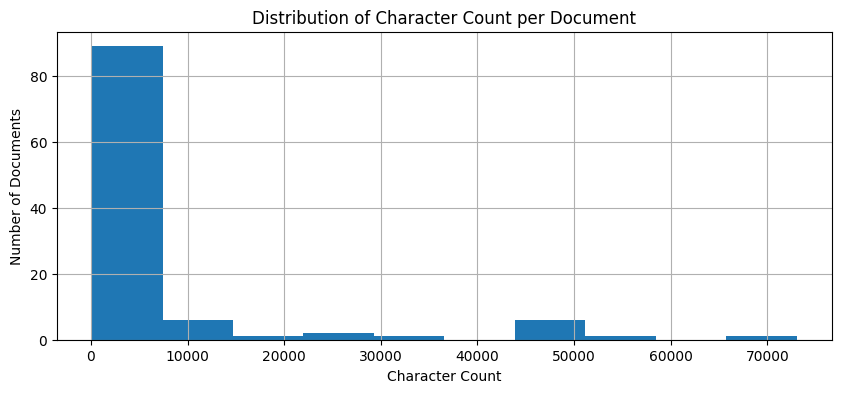

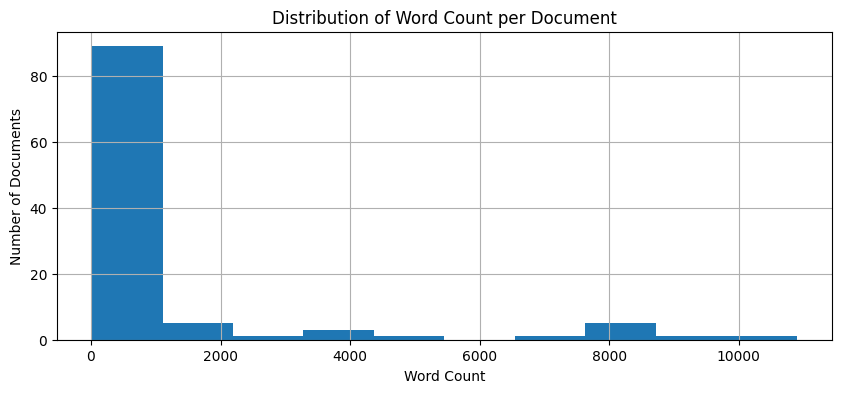

In [6]:
import pandas as pd

# Analyze character and word counts
data = []
for entry in successful_scrapes:
    text = entry['text']
    char_count = len(text)
    word_count = len(text.split())
    data.append({
        "url": entry['url'],
        "char_count": char_count,
        "word_count": word_count
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Describe the distribution
summary_stats = df.describe()

import matplotlib.pyplot as plt

# Plot histograms for both character and word counts
plt.figure(figsize=(10, 4))
plt.hist(df["char_count"], bins=10)
plt.title("Distribution of Character Count per Document")
plt.xlabel("Character Count")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(df["word_count"], bins=10)
plt.title("Distribution of Word Count per Document")
plt.xlabel("Word Count")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()



In [7]:
summary_stats

,char_count,word_count
count,107.000000,107.000000
mean,7532.028037,1166.196262
std,14316.707973,2215.873040
min,117.000000,18.000000
25%,376.000000,50.000000
50%,2532.000000,364.000000
75%,5736.500000,857.500000
max,73041.000000,10896.000000


In [8]:
from langchain.schema import Document

docs = [
    Document(page_content=entry['text'], metadata={"source": entry['url']})
    for entry in successful_scrapes
]


In [9]:
import os 
import tempfile
import pinecone
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langsmith import traceable
from writerai import Writer
from typing import List
from langchain.document_loaders import SitemapLoader
from pinecone import Pinecone, ServerlessSpec
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Pinecone as LangChainPinecone

# Initialize Pinecone instance
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

# Create an index if it does not exist
index_name = "niagara-docs-gpt"
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name, 
        dimension=3072,  # Adjust based on your embedding size
        metric="cosine",  # You can choose cosine or euclidean
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

# Initialize the embedding model
embd = OpenAIEmbeddings(model="text-embedding-3-large")

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200
)


doc_splits = text_splitter.split_documents(docs)

# Store vectors in Pinecone (using the LangChain wrapper)
vectorstore = LangChainPinecone.from_documents(doc_splits, embd, index_name=index_name, batch_size=10)

USER_AGENT environment variable not set, consider setting it to identify your requests.
C:\Users\pramo\AppData\Local\Temp\ipykernel_36400\2732734437.py:30: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embd = OpenAIEmbeddings(model="text-embedding-3-large")
